# ResNet50 Image Classification from COCO Format

This notebook trains a ResNet50 model for image classification using COCO format annotations.

## 1. Import Libraries

In [1]:
import json
import numpy as np
import cv2
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

e:\pyenv\.comvis\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
e:\pyenv\.comvis\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
e:\pyenv\.comvis\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runtime release.

TensorFlow version: 2.20.0
Keras version: 3.12.0


## 2. Configuration

In [ ]:
# Configuration parameters
IMG_SIZE = 224  # ResNet standard input size
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

# Dataset paths
DATASET_PATH = '../dashcam 2.v1i.coco/train'
ANNOTATIONS_FILE = '../dashcam 2.v1i.coco/train/_annotations.coco.json'

## 3. Load COCO Data

In [3]:
def load_coco_data(dataset_path, annotations_file):
    """Load images and labels from COCO format annotations"""
    dataset_path = Path(dataset_path)
    
    with open(annotations_file, 'r') as f:
        coco_data = json.load(f)
    
    # Create mappings
    images_info = {img['id']: img for img in coco_data['images']}
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    # Collect image-label pairs (one label per image)
    image_labels = {}
    for annotation in coco_data['annotations']:
        img_id = annotation['image_id']
        category_id = annotation['category_id']
        category_name = categories[category_id]
        
        # Store the first category found for each image
        if img_id not in image_labels:
            image_labels[img_id] = category_name
    
    # Load images
    x_data = []
    y_data = []
    
    print(f"Loading {len(image_labels)} images...")
    for img_id, label in image_labels.items():
        img_info = images_info[img_id]
        img_path = dataset_path / img_info['file_name']
        
        if img_path.exists():
            # Read and preprocess image
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            x_data.append(img)
            y_data.append(label)
        else:
            print(f"Warning: Image not found: {img_path}")
    
    x_data = np.array(x_data, dtype='float32') / 255.0
    y_data = np.array(y_data)
    
    return x_data, y_data

# Load the data
x_data, y_data = load_coco_data(DATASET_PATH, ANNOTATIONS_FILE)
print(f"\nLoaded {len(x_data)} images successfully!")

Loading 2463 images...

Loaded 2463 images successfully!


## 4. Encode Labels and Prepare Data

In [4]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)
y_categorical = keras.utils.to_categorical(y_encoded)

num_classes = len(label_encoder.classes_)

print(f"Dataset info:")
print(f"Total images: {len(x_data)}")
print(f"Image shape: {x_data.shape[1:]}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")
print(f"Class distribution: {dict(zip(label_encoder.classes_, np.bincount(y_encoded)))}")

Dataset info:
Total images: 2463
Image shape: (224, 224, 3)
Number of classes: 4
Classes: ['Mobil' 'Motor' 'Orang' 'Truk']
Class distribution: {np.str_('Mobil'): np.int64(525), np.str_('Motor'): np.int64(549), np.str_('Orang'): np.int64(243), np.str_('Truk'): np.int64(1146)}


## 5. Visualize Sample Images

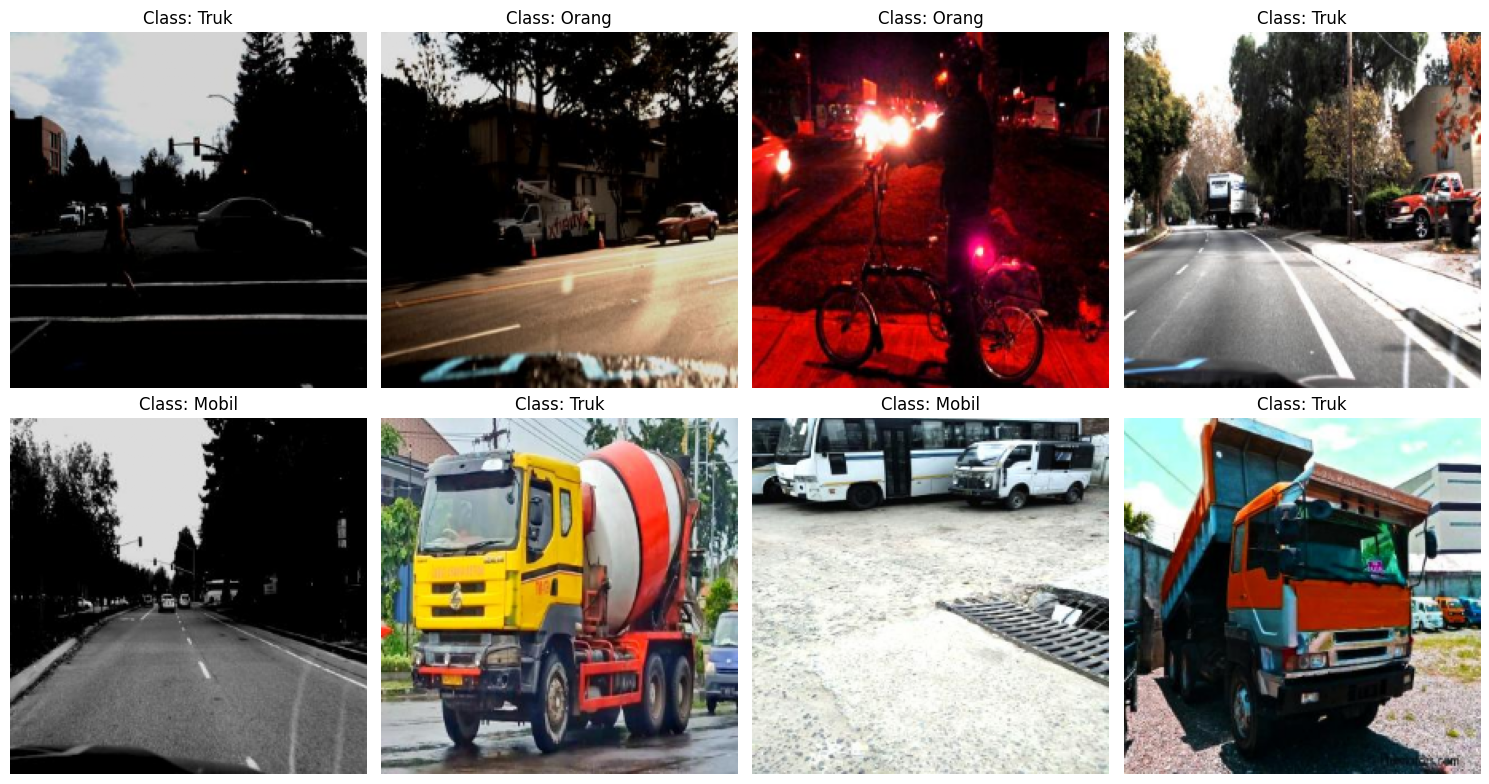

In [5]:
# Display some sample images
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

for i in range(8):
    idx = np.random.randint(0, len(x_data))
    axes[i].imshow(x_data[idx])
    axes[i].set_title(f"Class: {y_data[idx]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 6. Split Data into Training and Validation Sets

In [6]:
# Split data
x_train, x_val, y_train, y_val = train_test_split(
    x_data, y_categorical,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")

Training samples: 1970
Validation samples: 493


## 7. Create ResNet50 Model

In [7]:
def create_resnet_classifier(num_classes, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    """Create ResNet50 model for classification"""
    # Load pre-trained ResNet50 without top layers
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model, base_model

# Create model
model, base_model = create_resnet_classifier(num_classes)
print(model.summary())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 101s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,769,156 (94.49 MB)

 Trainable params: 1,181,444 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


## 8. Compile Model and Setup Callbacks

In [8]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Setup callbacks
checkpoint = ModelCheckpoint(
    'best_resnet_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, reduce_lr, early_stop]

## 9. Setup Data Augmentation

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode='nearest'
)

print("Data augmentation setup complete!")

Data augmentation setup complete!


## 10. Phase 1: Train with Frozen Base

In [10]:
print("=== Phase 1: Training with frozen base ===")
history1 = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

=== Phase 1: Training with frozen base ===
Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3842 - loss: 1.4181
Epoch 1: val_accuracy improved from None to 0.48682, saving model to best_resnet_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.4061 - loss: 1.3506 - val_accuracy: 0.4868 - val_loss: 1.2213 - learning_rate: 0.0010
Epoch 2/20
 1/61 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.3750 - loss: 1.3972

e:\pyenv\.comvis\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.48682 to 0.49290, saving model to best_resnet_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 35s 554ms/step - accuracy: 0.3750 - loss: 1.3972 - val_accuracy: 0.4929 - val_loss: 1.2198 - learning_rate: 0.0010
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4622 - loss: 1.2599
Epoch 3: val_accuracy improved from 0.49290 to 0.49493, saving model to best_resnet_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.4721 - loss: 1.2524 - val_accuracy: 0.4949 - val_loss: 1.1838 - learning_rate: 0.0010
Epoch 4/20
 1/61 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.4375 - loss: 1.3130
Epoch 4: val_accuracy improved from 0.49493 to 0.50304, saving model to best_resnet_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 0.4375 - loss: 1.3130 - val_accuracy: 0.5030 - val_loss: 1.1873 - learning_rate: 0.0010
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4595 - loss: 1.2535
Epoch 5: val_accuracy improved from 

## 11. Phase 2: Fine-tuning with Unfrozen Layers

In [11]:
print("=== Phase 2: Fine-tuning with unfrozen layers ===")

# Unfreeze base model
base_model.trainable = True

# Freeze early layers, unfreeze later layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

=== Phase 2: Fine-tuning with unfrozen layers ===
Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4572 - loss: 1.3858
Epoch 1: val_accuracy did not improve from 0.53144
61/61 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.4881 - loss: 1.2319 - val_accuracy: 0.4828 - val_loss: 1.1522 - learning_rate: 1.0000e-04
Epoch 2/100
 1/61 ━━━━━━━━━━━━━━━━━━━━ 2:31 3s/step - accuracy: 0.5312 - loss: 1.1021
Epoch 2: val_accuracy did not improve from 0.53144
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 324ms/step - accuracy: 0.5312 - loss: 1.1021 - val_accuracy: 0.4848 - val_loss: 1.1558 - learning_rate: 1.0000e-04
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5512 - loss: 1.1040
Epoch 3: val_accuracy did not improve from 0.53144
61/61 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.5511 - loss: 1.1015 - val_accuracy: 0.4828 - val_loss: 1.1899 - learning_rate: 1.0000e-04
Epoch 4/100
 1/61 ━━━━━━━━━━━━━━━━━━━━ 2:41 3s/step - accuracy: 0.5938 - loss: 0.9786
Epoch 4: val_accuracy d

KeyboardInterrupt: 

## 12. Plot Training History

In [ ]:
# Combine histories
def plot_history(history1, history2):
    # Combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axvline(x=20, color='r', linestyle='--', label='Fine-tuning starts')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(x=20, color='r', linestyle='--', label='Fine-tuning starts')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.show()

plot_history(history1, history2)

## 13. Final Evaluation

In [ ]:
print("=== Final Evaluation ===")
loss, accuracy = model.evaluate(x_val, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

## 14. Save Model and Label Encoder

In [ ]:
import pickle

# Save final model
model.save('final_resnet_classifier.keras')
print("Model saved as 'final_resnet_classifier.keras'")

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved as 'label_encoder.pkl'")

## 15. Test Predictions on Sample Images

In [ ]:
# Make predictions on validation set
predictions = model.predict(x_val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

# Display some predictions
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

for i in range(8):
    idx = np.random.randint(0, len(x_val))
    axes[i].imshow(x_val[idx])
    
    pred_label = label_encoder.classes_[predicted_classes[idx]]
    true_label = label_encoder.classes_[true_classes[idx]]
    confidence = predictions[idx][predicted_classes[idx]] * 100
    
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(f"Pred: {pred_label} ({confidence:.1f}%)\nTrue: {true_label}", color=color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()